In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy import stats
from timeit import default_timer as timer
from tqdm import tqdm

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Comment this line if want to work with GPU

In [3]:
from scdc.ensemble import Ensemble
from scdc.event import Event
from scdc.particle import Quasiparticle
from scdc.materials import ALUMINUM, NIOBIUM, SILICON
#from scdc import plot  # Contains matplotlib configuration code
from scdc.initial.distribution.integral import InitialSampler
from scdc.initial.halo import StandardHaloDistribution
from scdc.initial.response import HybridResponseFunction
from scdc.initial.matrix_element import FiducialMatrixElement

2022-01-21 20:31:34.074758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-01-21 20:31:34.074813: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
KMS = 3.33564e-6  # km/s in natural units

material = ALUMINUM
vdf = StandardHaloDistribution(
    v_0    = 220 * KMS / material.v, 
    v_esc  = 550 * KMS / material.v,
    v_wind = 230 * KMS / material.v
)
vdf_iso = StandardHaloDistribution(
    v_0    = 220 * KMS / material.v, 
    v_esc  = 550 * KMS / material.v,
    v_wind = 0 * KMS / material.v
)
response = HybridResponseFunction(material, 1) # The 1 is the coherence sign. Can be +1 or -1
me_light = FiducialMatrixElement(mediator_mass = 0)
me_heavy = FiducialMatrixElement(mediator_mass = 10)
m_nt     = np.concatenate((np.linspace(1, 9, 2) * 1e6, np.linspace(1, 9, 4) * 1e6)) / material.m # Dark matter masses
N_events = np.array( [100] ) # Numero de eventos observados

In [7]:
sim_light_energy_leaf_qp = []
sim_light_energy_leaf_ph = []
sim_light_dep_energy     = []
for i, vali in enumerate(tqdm(m_nt)):
    sampler_light    = InitialSampler(vali, me_light, material, response, vdf, n_cq = 20, n_rq = 20)
    simulation_light = sampler_light.ensemble(N_events[0])
    simulation_light.chain()
    sim_light_energy_leaf_qp.append(simulation_light.leaf_particles.quasiparticles.energy)
    sim_light_energy_leaf_ph.append(simulation_light.leaf_particles.phonons.energy)

    aux = np.zeros((N_events[0]))
    for j, valj in enumerate(simulation_light):
        aux[j] = sum(valj.leaf_particles.phonons.energy) + sum(valj.leaf_particles.quasiparticles.energy)
    sim_light_dep_energy.append(aux)
    

100%|█████████████████████████████████████| 6/6 [09:35<00:00, 95.97s/it]


In [8]:
sim_heavy_energy_leaf_qp = []
sim_heavy_energy_leaf_ph = []
sim_heavy_dep_energy     = []
for i, vali in enumerate(tqdm(m_nt)):
    sampler_heavy    = InitialSampler(vali, me_heavy, material, response, vdf, n_cq = 20, n_rq = 20)
    simulation_heavy = sampler_heavy.ensemble(N_events[0])
    simulation_heavy.chain()
    sim_heavy_energy_leaf_qp.append(simulation_heavy.leaf_particles.quasiparticles.energy)
    sim_heavy_energy_leaf_ph.append(simulation_heavy.leaf_particles.phonons.energy)
    
    aux = np.zeros((N_events[0]))
    for j, valj in enumerate(simulation_heavy):
        aux[j] = sum(valj.leaf_particles.phonons.energy) + sum(valj.leaf_particles.quasiparticles.energy)
    sim_heavy_dep_energy.append(aux)

100%|█████████████████████████████████| 6/6 [3:57:14<00:00, 2372.38s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.17, 700, 'PH')

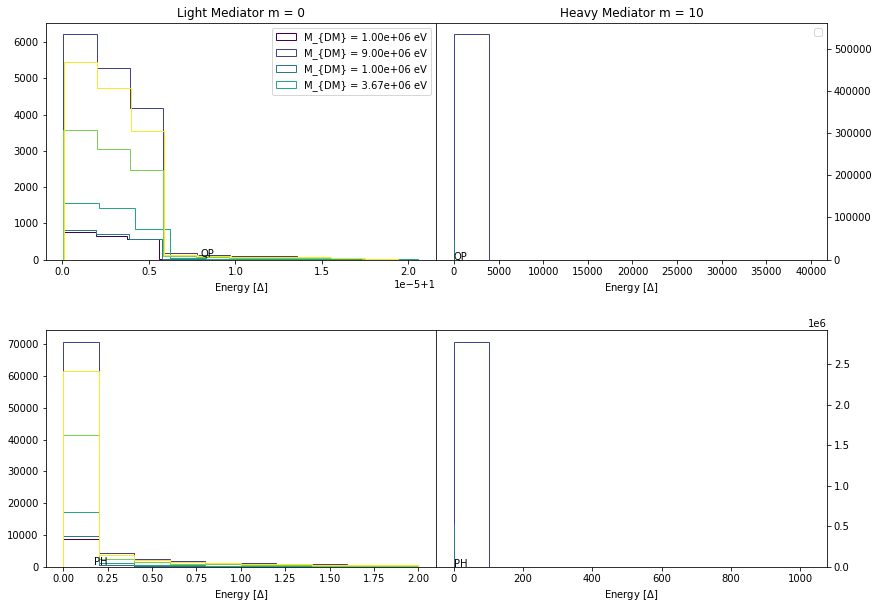

In [9]:
cmap = get_cmap('viridis', len(m_nt))

fig, ax = plt.subplots(2, 2, sharex = False, sharey = False, figsize = (14, 10), gridspec_kw = dict(hspace = 0.3, wspace = 0))

for i, vali in enumerate(m_nt):
    if i <= int(len(m_nt)/2):
        ax[0,0].hist(sim_light_energy_leaf_qp[i], histtype = 'step', color = cmap(i),
                label = 'M_{DM} = ' + '{:.2e}'.format(vali * material.m) + ' eV')
    else:
        ax[0,0].hist(sim_light_energy_leaf_qp[i], histtype = 'step', color = cmap(i))
    ax[1,0].hist(sim_light_energy_leaf_ph[i], histtype = 'step', color = cmap(i))

    
for i, vali in enumerate(m_nt):
    if i < 3:
        if i > int(len(m_nt)/2):
            ax[0,1].hist(sim_heavy_energy_leaf_qp[i], histtype = 'step', color = cmap(i),
                    label = 'M_{DM} = ' + '{:.2e}'.format(vali * material.m) + ' eV')
        else:
            ax[0,1].hist(sim_heavy_energy_leaf_qp[i], histtype = 'step', color = cmap(i))
        ax[1,1].hist(sim_heavy_energy_leaf_ph[i], histtype = 'step', color = cmap(i))

ax[0,1].legend()
ax[0,0].legend()
ax[0,0].set_title('Light Mediator m = 0')
ax[0,1].set_title('Heavy Mediator m = 10')

ax[0,0].set_xlabel('Energy [$\Delta$]')
ax[0,1].set_xlabel('Energy [$\Delta$]')
ax[0,1].yaxis.set_ticks_position('both')
ax[0,1].yaxis.tick_right()
ax[0,0].text(1 + 0.8e-5, 65, 'QP')
ax[0,1].text(1 + 0.8e-5, 65, 'QP')
 
ax[1,0].set_xlabel('Energy [$\Delta$]')
ax[1,1].set_xlabel('Energy [$\Delta$]')
ax[1,1].yaxis.set_ticks_position('both')
ax[1,1].yaxis.tick_right()
ax[1,0].text(0.17, 700, 'PH')
ax[1,1].text(0.17, 700, 'PH')


#plt.savefig('../graph/energy_leaf_QP+PH_AL.pdf')

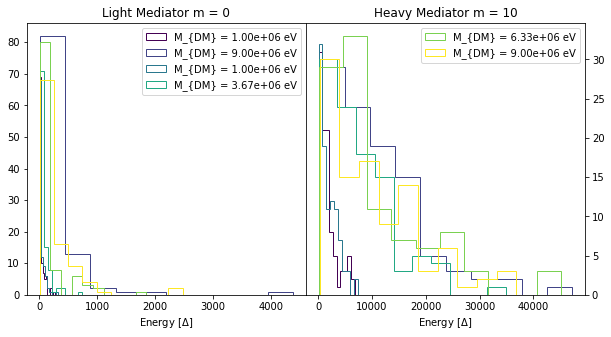

In [10]:
cmap = get_cmap('viridis', len(m_nt))

fig, ax = plt.subplots(1, 2, sharex = False, sharey = False, figsize = (10, 5), gridspec_kw = dict(hspace = 0.3, wspace = 0))

for i, vali in enumerate(m_nt):
    if i <= int(len(m_nt)/2):
        ax[0].hist(sim_light_dep_energy[i], histtype = 'step', color = cmap(i),
                label = 'M_{DM} = ' + '{:.2e}'.format(vali * material.m) + ' eV')
    else:
        ax[0].hist(sim_light_dep_energy[i], histtype = 'step', color = cmap(i))

    
for i, vali in enumerate(m_nt):
    if i > int(len(m_nt)/2):
        ax[1].hist(sim_heavy_dep_energy[i], histtype = 'step', color = cmap(i),
                label = 'M_{DM} = ' + '{:.2e}'.format(vali * material.m) + ' eV')
    else:
        ax[1].hist(sim_heavy_dep_energy[i], histtype = 'step', color = cmap(i))
    
ax[1].legend()
ax[0].legend()
ax[0].set_title('Light Mediator m = 0')
ax[1].set_title('Heavy Mediator m = 10')

ax[0].set_xlabel('Energy [$\Delta$]')
ax[1].set_xlabel('Energy [$\Delta$]')
ax[1].yaxis.set_ticks_position('both')
ax[1].yaxis.tick_right()

#plt.savefig('../graph/dep_energy_AL.pdf')